# 6장. 모델 평가와 하이퍼파라미터 튜닝의 모범 사례

## 6.1 파이프라인을 사용한 효율적인 워크플로

`pipeline` 클래스

### 6.1.1 위스콘신 유방암 데이터셋



In [1]:
# Importing Data
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data',
                 header=None)

In [2]:
# change the Character outcome to integer
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(['M', 'B'])

array([1, 0])

In [4]:
# training/test dataset splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.2,
                     stratify=y,
                     random_state=1)

### 6.1.2 파이프라인으로 변환기와 추정기 연결



In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [6]:
# pipeline 시각화
from sklearn import set_config
set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

## 6.2 k-겹 교차 검증을 사용한 모델 성능 평가

### 6.2.1 홀드아웃 방법

훈련 데이터셋을 훈련/검증 데이터셋으로 분리, 검증 데이터셋에서 모델 선택의 과정을 거침  
`모델 선택`: 주어진 분류 문제에서 튜닝할 파라미터/하이퍼파라미터의 최적값을 선택  
테스트 데이터셋에서 모델의 일반화 성능을 추정  
훈련/검증 데이터셋으로 나누는 방법에 따라 성능 추정이 민감할 수 있다.

### 6.2.2 k-겹 교차 검증

중복을 허용하지 않고 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눔  
k-1개의 폴드로 모델을 훈련하고, 나머지 하나의 폴드로 성능을 평가, 이 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻음  
모델의 평균 성능을 계산  

만족스러운 하이퍼파라미터 값을 찾은 후 `전체 훈련 데이터셋`을 이용하여 모델을 다시 훈련  
독립적인 테스트 데이터셋을 사용하여 최종 성능 추정  

좋은 기본값은 k=10 - reference 있음  
대규모 데이터셋에서는 k=5정도로도 평균 성능을 정확하게 추정할 수 있다.  

*Reference)* `leave-one-out cross-validation` - 하나의 훈련 샘플이 각 반복에서 테스트로 사용  

더 향상된 방법: `StratifiedKFold`: 각 폴드에서 클래스 비율이 전체 훈련 데이터셋에 있는 클래스 비율을 대표하도록 유지

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1,
                                              np.bincount(y_train[train]), score))


폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956


In [8]:
print('\nCV 정확도: %.3f +/- %.3f' %
      (np.mean(scores), np.std(scores)))


CV 정확도: 0.950 +/- 0.014


In [9]:
# 교차 검증 함수를 사이킷런을 이용하여 위의 코드를 좀 더 간결하고 편하게
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV 정확도 함수: %s' % scores)

CV 정확도 함수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [10]:
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                 np.std(scores)))

CV 정확도: 0.950 +/- 0.014


*Reference*
`cross_validate` 함수: 각 폴드에서 훈련과 테스트에 걸린 시간을 반환, scoring 매개변수에 지정한 평가 지표마다 훈련 점수와 테스트 점수를 반환  
`cross_val_predict` 함수: 훈련 데이터셋의 각 샘플이 테스트 폴드가 되었을 때 만들어진 예측을 반환 - 바람직한 일반화 성능 추정은 아님  

## 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

### 6.3.1 학습 곡선으로 편향과 분산 문제 분석

편향이 높은 모델: 과소적합, 특성을 추가, 규제 강도를 약화  
분산이 높은 모델: 과대적합, 특성 선택 (GOTO: chapter 4), 특성 추출 (GOTO: chapter 5), 규제 강도를 증가, 데이터를 더 모으기  


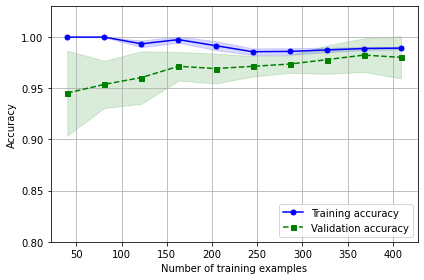

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',
                                           random_state=1))

train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipe_lr,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(
                       0.1, 1.0, 10),
                   cv=10,
                   n_jobs=1
                   )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean+train_std,
                 train_mean-train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean+test_std,
                 test_mean-test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

* 샘플 개수가 250 정도일 때 훈련과 검증 정확도 사이가 줄어들면서 분산도 작음  
* `learning_curves()`의 그 외 parameter들:  
    1) `train_sizes` 기본값은 np.linspace(0.1, 10, 5)
    2) `cv=5`가 기본값
    3) `shuffle=True` 훈련 데이터셋을 사용하기 전 섞기
    4) `return_times=True` 훈련과 평가에 걸린 시간 반환
    5) `fit_params` fit메서드에 필요한 매개변수와 값을 딕셔너리 형태로 지정할 수 있는 매개변수

### 6.3.2 검증 곡선으로 과대적합과 과소적합 조사

모델 파라미터 값의 함수로 그래프를 그림

/Users/sunghyouk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sunghyouk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

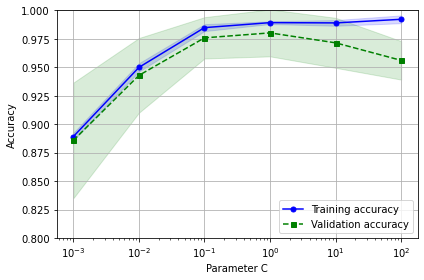

In [12]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean+train_std,
                 train_mean-train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range,
                 test_mean+test_std,
                 test_mean-test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

## 6.4 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

### 6.4.1 그리드 서치를 사용한 하이퍼파라미터 튜닝

리스트로 지정된 여러 가지 하이퍼파라미터 값 전체를 모두 조사  


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [14]:
# test data에 적용
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


In [15]:
# RandomizedSearchCV를 사용하기 - grid search는 계산 비용이 너무 많이 든다.
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
distribution = loguniform(0.0001, 1000.0)
param_dist = [{'svc__C': distribution,
               'svc__kernel': ['linear']},
              {'svc__C': distribution,
               'svc__gamma': distribution,
               'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


In [16]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
hgs = HalvingGridSearchCV(estimator=pipe_svc,
                          param_grid=param_grid,
                          cv=10,
                          n_jobs=-1, verbose=1)
hgs = hgs.fit(X_train, y_train)
print(hgs.best_score_)
print(hgs.best_params_)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 40
max_resources_: 455
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 40
Fitting 10 folds for each of 72 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 24
n_resources: 120
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 8
n_resources: 360
Fitting 10 folds for each of 8 candidates, totalling 80 fits
0.9887301587301588
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [17]:
# 적합한 파라메터 조합을 찾는데 얼마나 걸렸을까?
print(np.sum(hgs.cv_results_['mean_fit_time']))

0.37900736331939694


In [18]:
# 샘플 개수와 후보 개수가 저장되어 있는 곳
print('자원 리스트: ', hgs.n_resources_)
print('후보 리스트: ', hgs.n_candidates_)

자원 리스트:  [40, 120, 360]
후보 리스트:  [72, 24, 8]


### 6.4.2 중첩 교차 검증을 사용한 알고리즘 선택


In [19]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                 np.std(scores)))

CV 정확도: 0.974 +/- 0.015


## 6.5 여러 가지 성능 평가 지표

### 6.5.1 오차 행렬


In [20]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


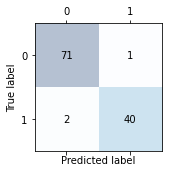

In [21]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

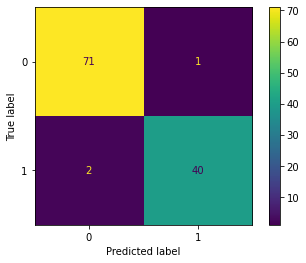

In [22]:
# 추가
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe_svc, X_test, y_test)
plt.show()

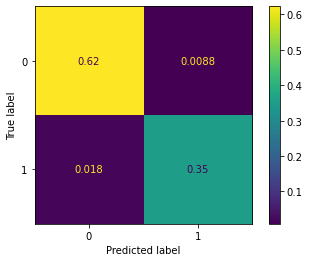

In [23]:
plot_confusion_matrix(pipe_svc, X_test, y_test,
                      normalize='all')
plt.show()

### 6.5.2 분류 모델의 정밀도와 재현율 최적화

* 오차
* 정확도 = 1-오차
* 양성 예측률
* 음성 예측률
* 정밀도
* 재현율 = 양성 예측률
* F1-점수

In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('정밀도: %.3f' % precision_score(
    y_true=y_test, y_pred=y_pred
))
print('재현율: %.3f' % recall_score(
    y_true=y_test, y_pred=y_pred
))
print('F1: %.3f' % f1_score(
    y_true=y_test, y_pred=y_pred
))

정밀도: 0.976
재현율: 0.952
F1: 0.964
